## Zillow competition kaggle

### Predict LogError based on House features

logerror=log(Zestimate)−log(SalePrice)

In [924]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import sys
from sklearn import linear_model

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.linear_model import LassoCV

from __future__ import division

from sklearn.linear_model import LinearRegression

In [3]:
# prop = pd.read_csv('/home/pranay/Downloads/zillow/properties_2016.csv')
prop = pd.read_csv('/home/blackstone/portfolio/zillow/properties_2016.csv')

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
train = pd.read_csv('/home/blackstone/portfolio/zillow/train_2016_v2.csv')

In [867]:
train.head()

,parcelid,logerror,transactiondate,yymm,abslogerror,month
0,11016594,0.0276,2016-01-01,2016-01,0.0276,01
1,14366692,-0.1684,2016-01-01,2016-01,0.1684,01
2,12098116,-0.0040,2016-01-01,2016-01,0.0040,01
3,12643413,0.0218,2016-01-02,2016-01,0.0218,01
4,14432541,-0.0050,2016-01-02,2016-01,0.0050,01


In [721]:
df_train = train.merge(prop, on='parcelid', how='left')

In [722]:
# Make a separate column for month and year
train['yymm'] = train['transactiondate'].apply(lambda x: x[0:7])
train['abslogerror'] = train['logerror'].apply(lambda x: abs(x))
train.transactiondate[10][5:7]
train['month'] = train['transactiondate'].apply(lambda x: x[5:7])

In [ ]:
# Distribution of log error
sns.distplot(train.logerror, kde=False, bins=400)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 6)
plt.xlim(-0.5, 0.5)

In [ ]:
# Distribution of absolute log error
sns.distplot(abs(train.logerror), kde=False, bins=400)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 6)
plt.xlim(0, 0.5)

In [ ]:
#Change in Absolute Log Error over the months in 2016 transactions
over_time = train.groupby(['month']).abslogerror.mean().sort_index()
over_time

plt.figure()
ax = plt.axes()

ax.plot(over_time.index, over_time.values)
plt.xlabel('Month in 2016')
plt.ylabel('Absolute Log Error')
plt.show()

In [872]:
def checkNull(cols):
    for column in cols:
        perc = df_train[column].isnull().value_counts(normalize=True)[0]*100
        print "%f percent non-null values in column %s"%(perc, column)

In [ ]:
checkNull(df_train.columns)

In [ ]:
df_train.apply(lambda x: x.isnull().value_counts(normalize=True)[0]).sort_values()

In [900]:
# Creating training set
x_train = df_train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode', 'rawcensustractandblock', 'propertyzoningdesc', 'regionidzip', 'censustractandblock'], axis =1)

In [877]:
# Separating based on dtypes
object_columns = x_train.dtypes[x_train.dtypes == object].index
float_columns = x_train.dtypes[x_train.dtypes == 'float64'].index

count_columns = x_train[float_columns].filter(like='cnt').columns
id_columns = x_train[float_columns].filter(like='id').columns
feet_columns = x_train[float_columns].filter(like='feet').columns
sqft_columns = x_train[float_columns].filter(like = 'sqft').columns
feet_columns

Index([u'calculatedfinishedsquarefeet', u'finishedsquarefeet12',
       u'lotsizesquarefeet'],
      dtype='object')

In [ ]:
[column for column in float_columns if column not in count_columns and column not in id_columns and column not in
feet_columns and column not in sqft_columns]

In [752]:
categorical = ['airconditioningtypeid', 'architecturalstyletypeid',
       'buildingclasstypeid', 'buildingqualitytypeid', 'decktypeid',
       'heatingorsystemtypeid', 'pooltypeid10', 'pooltypeid2',
       'pooltypeid7', 'propertylandusetypeid', 'storytypeid',
       'typeconstructiontypeid', 'yearbuilt', 'assessmentyear', 'taxdelinquencyyear', 'propertycountylandusecode',
              'hashottuborspa', 'propertyzoningdesc', 'fireplaceflag', 'regionidzip', 'fips', 'regionidcity', 'regionidcounty', 'regionidneighborhood',
       'regionidzip', 'rawcensustractandblock', 
               'taxdelinquencyflag', 'censustractandblock', 'target']

numerical = ['finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13',
       'finishedsquarefeet15', 'finishedsquarefeet50',
       'finishedsquarefeet6', 'lotsizesquarefeet', 'basementsqft', 'garagetotalsqft', 'yardbuildingsqft17',
       'yardbuildingsqft26', 'taxamount', 'poolsizesum', 'landtaxvaluedollarcnt', 'taxvaluedollarcnt', 'structuretaxvaluedollarcnt',
            'poolcnt', 'roomcnt', 'unitcnt', 'calculatedbathnbr', 'threequarterbathnbr', 'numberofstories', 
            'garagecarcnt', 'fireplacecnt','bedroomcnt', 'fullbathcnt', 'bathroomcnt', 'latitude', 'longitude']

In [895]:
#Pick columns with more than 60% non-null values
# good_features = data.apply(lambda x: x.isnull().value_counts(normalize=True)[0] > 0.7).index
good_features = x_train.apply(lambda x: x.isnull().value_counts(normalize=True)[0] > 0.6)

In [ ]:
good_features = good_features[good_features].index
good_features

In [ ]:
#### getting only columns from good_features
cat_col = [column for column in good_features if column in categorical]
cat_col

In [ ]:
#getting only columns from good_features
numerical = [column for column in good_features if column in numerical]
numerical

In [901]:
#only index good features from the data
x_train = x_train[good_features]

In [902]:
numeric_data = x_train[numerical]

In [ ]:
#Getting correlation more than 0.7
cor_df = numeric_data.corr()
cor_df[cor_df.apply(lambda x: x > 0.7)]

In [903]:
numeric_data = numeric_data.drop(['calculatedbathnbr', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fullbathcnt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt'], axis = 1)

In [ ]:
numeric_data.columns

In [905]:
#impute numeric columns with mean
numeric_data = numeric_data.apply(lambda x: x.fillna(x.median()))

In [906]:
#impute categorical columns with mode
categorical_data = x_train[cat_col].apply(lambda x: x.fillna(x.mode()[0]))

In [907]:
#convert float columns to object for dummy variable creation
for c, dtype in zip(categorical_data.columns, categorical_data.dtypes):
    if dtype == np.float64:
        categorical_data[c] = categorical_data[c].astype(int).astype(str)


In [ ]:
categorical_data.dtypes

In [908]:
categorical_data['yearbuilt'] = categorical_data['yearbuilt'].astype(int)

In [909]:
numeric_data['age'] = categorical_data.yearbuilt.apply(lambda x: 2015 - x)

In [769]:
numeric_data['roomcnt'] = numeric_data.apply(lambda x: 1 if (x.any()==0) else x)

In [ ]:
categorical_data = categorical_data.drop('assessmentyear', axis = 1)

In [912]:
categorical_data = categorical_data.drop('yearbuilt', axis = 1)

In [913]:
cat_dummies = pd.get_dummies(categorical_data)

In [914]:
#Concatenate numerical and dummied data frames
combined = pd.concat([cat_dummies, numeric_data], axis=1)

In [916]:
# train_y = df_train.logerror.values
train_y = df_train.logerror
train_x = combined

In [ ]:
train_x.head()

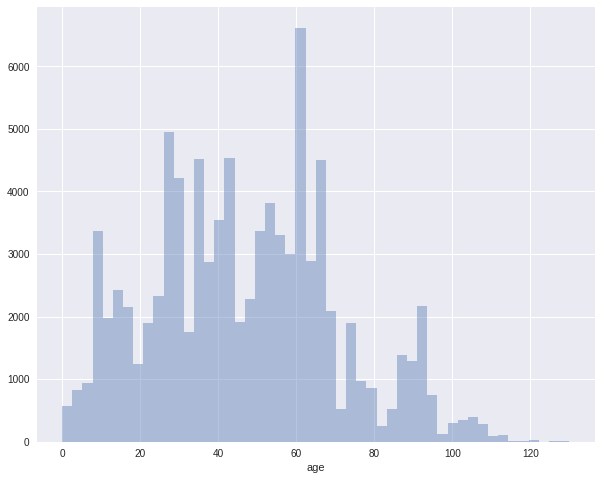

In [817]:
#plot age of houses
sns.distplot(train_x.age, kde=False)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 8)

(0, 20.0)

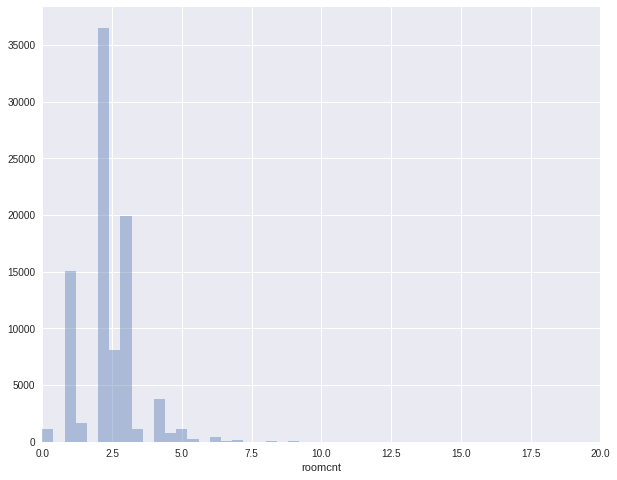

In [810]:
#plot room count
sns.distplot(train_x.roomcnt, kde=False)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 8)
plt.xlim(0,train_x.roomcnt.max())

(0, 10)

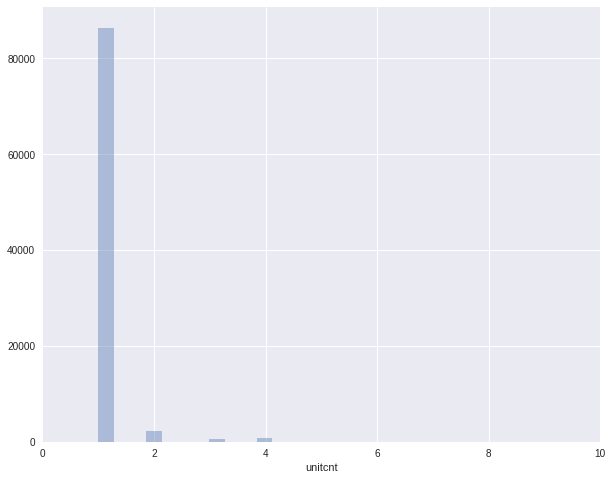

In [815]:
#plot room unitcnt
sns.distplot(train_x.unitcnt, kde=False, bins=500)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 8)
plt.xlim(0,10)

In [935]:
clf = LinearRegression()

In [925]:
cv_outer = KFold(len(train_x), n_folds=5)
lasso = LassoCV(cv=3)

In [926]:
scores = cross_val_score(lasso, train_x, train_y, cv=cv_outer)

In [931]:
scores.mean()

-0.00088394749895144282

In [933]:
# scores = cross_val_score(clf, train_x, train_y, cv=5, scoring='neg_mean_squared_error')
scores = cross_val_score(clf, train_x, train_y, cv=10)

In [934]:
scores.mean()

-85162271.437544003

In [839]:
split = int(x_train.shape[0] * 0.6)
train_x, train_y, val_x, val_y = train_x[:split], train_y[:split], train_x[split:], train_y[split:]

In [840]:
alg = LogisticRegression()
alg.fit(train_x, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [841]:
coefs = alg.coef_.reshape(226,)
colnames = train_x.columns.values

In [842]:
coefs = pd.Series(coefs)
coefs.index = colnames

In [858]:
coefs.sort_values(ascending=False)

lotsizesquarefeet            2.258360e-07
taxamount                    1.770712e-07
roomcnt                      9.061791e-11
bathroomcnt                  9.061791e-11
bedroomcnt                   6.014168e-11
heatingorsystemtypeid_2      1.502102e-11
buildingqualitytypeid_4      1.282419e-11
propertylandusetypeid_266    5.913709e-12
fips_6059                    4.993706e-12
regionidcounty_1286          4.993706e-12
buildingqualitytypeid_1      2.999644e-12
regionidcity_52650           2.153364e-12
regionidcity_50749           1.942820e-12
regionidcity_51239           1.918966e-12
buildingqualitytypeid_10     1.852369e-12
regionidcity_54311           1.836130e-12
regionidcity_20008           1.713920e-12
fips_6111                    1.553741e-12
regionidcounty_2061          1.553741e-12
regionidcity_24384           1.487815e-12
regionidcity_25218           1.425429e-12
regionidcity_54053           1.356629e-12
regionidcity_37015           1.317824e-12
regionidcity_52835           1.250

In [ ]:
r2_score(predicted, val_y)

In [ ]:
accuracy_score(predicted, val_y)

In [ ]:
mse = np.mean((predicted -val_y)**2)